In [1]:
#step 1 import required packages
import pandas as pd # load pandas package for importing csv files in correct format
# import as defines the identifier you want to use for the function e.g in this case 
# pd will call the pandas package
import matplotlib # load matplotlib package for plotting graphs
import os

In [2]:
#step 2 load open prescribing measures data to filter out a subset for testing all scripts
data = pd.read_csv('measures.csv', sep=',') #data is sepperated by , commas

In [3]:
#step 3 check data has imported correctly 
data.head(3) # Show top 3 entries to confirm successful data import

,measure,org_type,org_id,org_name,date,numerator,denominator,calc_value,percentile
0,ktt9_antibiotics,practice,P84650,THE ALEXANDRA PRACTICE,2014-10-01,199.0,3106.653507,0.064056,9.181078
1,ktt9_antibiotics,practice,P84673,ANCOATS URBAN VILLAGE MEDICAL PRACTICE,2014-10-01,463.0,4252.799604,0.108869,75.864700
2,ktt9_antibiotics,practice,P84071,WILBRAHAM SURGERY,2014-10-01,219.0,2275.856965,0.096227,57.540692


In [4]:
dataframe = pd.DataFrame(data) #Convert imported data to a dataframe using pandas
dataframe.head(3) #view the first three lines of the dataframe to check import has been successful

,measure,org_type,org_id,org_name,date,numerator,denominator,calc_value,percentile
0,ktt9_antibiotics,practice,P84650,THE ALEXANDRA PRACTICE,2014-10-01,199.0,3106.653507,0.064056,9.181078
1,ktt9_antibiotics,practice,P84673,ANCOATS URBAN VILLAGE MEDICAL PRACTICE,2014-10-01,463.0,4252.799604,0.108869,75.864700
2,ktt9_antibiotics,practice,P84071,WILBRAHAM SURGERY,2014-10-01,219.0,2275.856965,0.096227,57.540692


In [5]:
dataframe_Sort = dataframe.sort_values("numerator") #sort dataframe by number of prescriptions
#To sort the dataframe by additional variables (i.e. collemns) e.g. then by date add ', "date"' after "numerator"
#This process is described in the following URL: 
#https://www.geeksforgeeks.org/python-pandas-dataframe-sort_values-set-2/
dataframe_Sort.head(6) # view the first 6 lines of the dataframe to check the data has been sorted correctly

,measure,org_type,org_id,org_name,date,numerator,denominator,calc_value,percentile
2050,ktt9_antibiotics,practice,P84659,DR HUSSAIN'S PRACTICE,2016-07-01,0.0,0.0,NaN,NaN
1003,ktt9_antibiotics,practice,P84063,DR CHEN & DAVIS,2015-08-01,0.0,0.0,NaN,NaN
1011,ktt9_antibiotics,practice,P84057,KAYA PRACTICE,2015-08-01,0.0,0.0,NaN,NaN
3978,ktt9_antibiotics,practice,P84623,ALEESHAN MEDICAL CENTRE,2018-03-01,0.0,0.0,NaN,NaN
1014,ktt9_antibiotics,practice,P84677,DIDSBURY MEDICAL CENTRE- DR ASHWORTH,2015-08-01,0.0,0.0,NaN,NaN
3974,ktt9_antibiotics,practice,P84063,DR CHEN & DAVIS,2018-03-01,0.0,0.0,NaN,NaN


In [6]:
#successfull sorthing as first 6 rows = 0.00
#database entries (rows) with 0.0 prescriptions need to be removed from the database as these are artifacts
#if these values are not removed outlier values will be caluclated incorrectly.
#No active surgery will have 0 prescriptions
PCo = len(dataframe_Sort[dataframe_Sort['numerator'] == 0.0]) #count number of rows with 0 prescriptions
if PCo>0: #Create an if statement to interpret the presence of rows with 0 prescriptions
    print('This dataset contains', PCo, 
          'entries with 0 prescriptions. These entries will be removed from the dataset.')
            #print warning meassage to user outlining the number of blank rows detected using an if statement 
else:
    print('no errors were detected') #Notify the user if no rows were found with zero prescriptions

This dataset contains 345 entries with 0 prescriptions. These entries will be removed from the dataset.


In [11]:
# step 8 Identify all database entries with >0.0 prescriptions and remove
AntiP =  dataframe_Sort['numerator']>0.0 #Identify all rows with a prescription value greater than 0.0
AntiP.head(3) # Values =0 ='FALSE'
AntiP.tail(3) # Values >0 ='TRUE'
df_SF = dataframe_Sort[AntiP] #Filter the dataset, keeping all rows with prescriptions >0 (i.e. = 'TRUE')
df_SF.head(3)#check rows with 0 have been filtered out of the dataset
#First values of prescripitions in dataset = 1.0
#Rows with values of 0 have been filtered correctly
#Antibiotics per 1000. Values =0.0 = <1 prescription per 1000 people? Check openprescribing.net description?
#Check all rows with 0 prescriptions have been removed
df_SF_min = min(df_SF.numerator) # check minimum value is not 0.0
print('The smallst number of prescriptions is:', df_SF_min)

The smallst number of prescriptions is: 1.0


In [15]:
#Calculate IQR
q1 = df_SF['numerator'].quantile(0.25)#Q1
q3 = df_SF['numerator'].quantile(0.75)#Q3
iqr=df_SF['numerator'].quantile(0.75)-df_SF['numerator'].quantile(0.25) #calculate IQR
print("The interquartile range:", iqr) #print IQR

The interquartile range: 219.0


In [18]:
#Calclate lower limit for outliers
LowOut = q1 - 1.5 * iqr #lower bound
print('The lower boundary for outliers is:', LowOut) #print lower boundary

The lower boundary for outliers is: -151.5


In [20]:
#Calculate upper limit for outliers
HighOut = q3 + 1.5 * iqr #upper bound
print('The upper boundary for outliers is:', HighOut) #print upper boundary

The upper boundary for outliers is: 724.5


In [24]:
# Identify all rows with high and low outliers 
Outliers = df_SF[(df_SF['numerator'] < LowOut) | (df_SF['numerator'] > HighOut)] #pipe (|) = OR
Outliers.head(3) # print first three lines of the dataframe containing outliers.
#count number of outliers and print message to inform the user
NoOutliers = len(Outliers['numerator'])
print('This dataset contains', NoOutliers, 'Outliers, represented by the circles in the boxplot below.')

This dataset contains 154 Outliers, represented by the circles in the boxplot below.


{'whiskers': [<matplotlib.lines.Line2D at 0x7f68cad5e320>,
 'caps': [<matplotlib.lines.Line2D at 0x7f68cad5ea20>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f68cad4feb8>],
 'medians': [<matplotlib.lines.Line2D at 0x7f68cad5ee48>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f68cad69438>],
 'means': []}

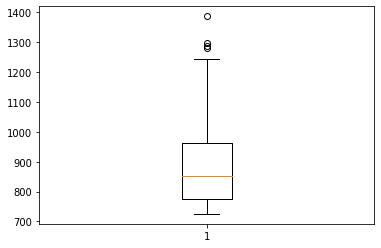

In [32]:
import matplotlib #import matplotlib package for plotting boxplots
import matplotlib.pyplot as plt #import matplotlib.pyplot package for plotting boxplots
plt.boxplot(Outliers.numerator) #plot boxplot for outliers...

In [33]:
GPlist=Outliers.org_name.unique() # list unique name of practices with prescription outliers.
print('This is a list of all the GP practices where antibioitc prescrition numbers have been identified as outliers:',
     GPlist) # print list of all GP practices with prescribing outliers

This is a list of all the GP practices where antibioitc prescrition numbers have been identified as outliers: ['BOWLAND MEDICAL PRACTICE' 'BENCHILL MEDICAL PRACTICE'
 'THE AVENUE MEDICAL CENTRE' 'VALENTINE MEDICAL CENTRE'
 'NEW COLLEGIATE MEDICAL CENTRE' "ST GEORGE'S MEDICAL CENTRE"
 'GORTON MEDICAL CENTRE' 'DIDSBURY MEDICAL CENTRE - DR WHITAKER'
 'NORTHENDEN GROUP PRACTICE' 'BODEY MEDICAL CENTRE'
 'PEEL HALL MEDICAL CENTRE' 'THE ROBERT DARBISHIRE PRACTICE'
 'CITY HEALTH CENTRE']


In [34]:
Outliers[Outliers['org_name'].str.match('CITY HEALTH CENTRE')]
#identify all outliers from the GP practice 'CITY HEALTH CENTRE'
#Add line to Sam's graph of outlier range (same for all datasets)

,measure,org_type,org_id,org_name,date,numerator,denominator,calc_value,percentile
278,ktt9_antibiotics,practice,Y02849,CITY HEALTH CENTRE,2014-12-01,854.0,3302.252596,0.258611,98.944557
2702,ktt9_antibiotics,practice,Y02849,CITY HEALTH CENTRE,2017-02-01,857.0,4493.070547,0.190738,99.240506
1862,ktt9_antibiotics,practice,Y02849,CITY HEALTH CENTRE,2016-05-01,881.0,3880.348166,0.227041,99.370079
2149,ktt9_antibiotics,practice,Y02849,CITY HEALTH CENTRE,2016-08-01,902.0,4081.068467,0.221021,99.445105
2966,ktt9_antibiotics,practice,Y02849,CITY HEALTH CENTRE,2017-04-01,912.0,4732.845752,0.192696,99.397268
2100,ktt9_antibiotics,practice,Y02849,CITY HEALTH CENTRE,2016-07-01,917.0,4081.068467,0.224696,99.392258
1705,ktt9_antibiotics,practice,Y02849,CITY HEALTH CENTRE,2016-03-01,930.0,3688.663327,0.252124,99.205315
3063,ktt9_antibiotics,practice,Y02849,CITY HEALTH CENTRE,2017-05-01,938.0,4773.494780,0.196502,99.394917
2001,ktt9_antibiotics,practice,Y02849,CITY HEALTH CENTRE,2016-06-01,942.0,3880.348166,0.242762,99.409449
3415,ktt9_antibiotics,practice,Y02849,CITY HEALTH CENTRE,2017-09-01,945.0,4921.691134,0.192007,99.510404


In [ ]:
##Import matplotlib for making graphs,
##import pandas for reading in dataframe
import matplotlib.pyplot as plt
import matplotlib.dates as dt
import numpy
import pandas as pd

In [ ]:
##Read in our data and assign it to variable "data".
data = pd.read_csv("measures.csv", sep =',')

##To test we have imported data correctly,
##import first four rows, which includes column headers
print(data.loc[0:3,:])

In [ ]:
'''The first definition provides the user the ability to view the trends data for every surgery
within a particular geographical area.'''
def Plot_trends_all_surgeries(data):
    unique_org_ids = data['org_id'].unique() ##Get a list of the surgeries

    ax = plt.gca() ##Set the default axis for the graph

    for orgs_id in unique_org_ids: ##For each surgery in the list of unique surgery
        new_dataframe = data[data['org_id'] == str(orgs_id)] ##Get a new dataframe subset just for the one surgery 
        graph_points = new_dataframe[['date','numerator']] ##From the new dataframe, get the date and prescription number
    
        graph_points.plot(x='date',y='numerator', ax = ax) ##Plot date and prescriptions on same axis for all surgeries

    ax.get_legend().remove() ##Remove legend from graph, as very messy.
    plt.gcf().autofmt_xdate() ##Format the x-axis for date data
    plt.show() ##Show the plot
    
'''This function shows the summed prescribing information for every surgery within the geographical area for
a particular timepoint. This is displayed from 2014-2019'''
def Plot_trends_combined_surgeries(data):
    unique_date_ids = data['date'].unique() ##Get a list of all the reporting dates

    dates_axis = [] ##Initiate a list for dates
    summed_axis = [] ##Initiate a list to sum all data for that date

    for dates in unique_date_ids:
        dates_axis.append(dates) ##Append iterative dates to date_axis list
        new_dataframe = data[data['date'] == dates] ##Subset dataframe just for iterative date
        summed = new_dataframe['numerator'].sum() ##Sum the prescribing column
        summed_axis.append(summed) ##Append the sum to the list
    
    new_df = pd.DataFrame({'date_axis':dates_axis,'summed_axis':summed_axis}) ##Turn lists into dataframe to turn into a graph

    new_df.plot(x = 'date_axis', y = 'summed_axis') ##Plot new graph

    plt.gcf().autofmt_xdate() ##Format date axis
    plt.show() ##Show the plot.
    
'''This function allows the user to provide the data, and provide either the name or the ID
of a surgery, and see the trend over time just for that surgery. This can be used as an investigational
tool into surgeries of interest (e.g outliers)

Note: Using organisation names are case sensitive'''
def Plot_trends_pick_surgeries(data, name):
    if data['org_id'].str.endswith(name).any():
            
        ax = plt.gca() ##Set the default axis for the graph
    
        new_dataframe = data[data['org_id'] == str(name)] ##Get a new dataframe subset just for the one surgery 
        graph_points = new_dataframe[['date','numerator']] ##From the new dataframe, get the date and prescription number
    
        graph_points.plot(x='date',y='numerator', ax = ax) ##Plot date and prescriptions on same axis for all surgeries

        ax.legend(loc = 'upper right', labels=new_dataframe.iloc[0]['org_id'])
        plt.gcf().autofmt_xdate() ##Format the x-axis for date data
        plt.show() ##Show the plot
        
    elif data['org_name'].str.endswith(name).any():
        
        ax = plt.gca() ##Set the default axis for the graph
    
        new_dataframe = data[data['org_name'] == str(name)] ##Get a new dataframe subset just for the one surgery 
        graph_points = new_dataframe[['date','numerator']] ##From the new dataframe, get the date and prescription number
    
        graph_points.plot(x='date',y='numerator', ax = ax) ##Plot date and prescriptions on same axis for all surgeries

        ax.legend(loc = 'upper right', labels=new_dataframe.iloc[0]['org_id'])
        plt.gcf().autofmt_xdate() ##Format the x-axis for date data
        plt.show() ##Show the plot
        
        
    else:
        print('Could not find surgery!')
        

'''This function allows a user to pick any two surgeries and plot the prescribing information
on the same axis for both surgeries. This can be used to directly compare the prescribing
information for both surgeries.

So far, this function only works with organisation IDs and not organisation names.'''
def Plot_trends_two_surgeries_by_IDs(data, name1, name2):
    if data['org_id'].str.endswith(name1).any() & data['org_id'].str.endswith(name2).any():
    
        ax = plt.gca() ##Set the default axis for the graph

        for two_id in name1, name2: ##For each surgery in the list of unique surgery
            new_dataframe = data[data['org_id'] == str(two_id)] ##Get a new dataframe subset just for the one surgery 
            graph_points = new_dataframe[['date','numerator']] ##From the new dataframe, get the date and prescription number
    
            graph_points.plot(x='date',y='numerator', ax = ax) ##Plot date and prescriptions on same axis for all surgeries

        new_dataframe1 = data[data['org_id'] == str(name1)] ##Get a new dataframe subset just for the one surgery 
        legend_points1 = new_dataframe1[['org_id','org_name']] ##From the new dataframe, get the date and prescription number
        
        new_dataframe2 = data[data['org_id'] == str(name2)] ##Get a new dataframe subset just for the one surgery 
        legend_points2 = new_dataframe2[['org_id','org_name']] ##From the new dataframe, get the date and prescription number
                
        legendname1 = legend_points1.iloc[0]['org_id'] + ', ' + legend_points1.iloc[0]['org_name']
        legendname2 = legend_points2.iloc[0]['org_id'] + ', ' + legend_points2.iloc[0]['org_name']
        
        ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2), labels=(legendname1, legendname2))
        plt.gcf().autofmt_xdate() ##Format the x-axis for date data
        plt.show() ##Show the plot
    
    else:
        print('One of the surgery IDs is incorrect!')

In [ ]:
Plot_trends_all_surgeries(data)
Plot_trends_combined_surgeries(data)
Plot_trends_pick_surgeries(data, 'P84071')
Plot_trends_two_surgeries_by_IDs(data, 'P84071', 'P84049')

In [ ]:
unique_outlier_dates = Outliers['date'].unique() ##Get a list outliers at unique dates

In [ ]:
x1 = min(data.date) #set x coordinate for earliest date
x2 = max(data.date) # set x coordinate for latest date
y = HighOut # set y as the upper bound for outliers
l1 = [(x1,y),(x2,y)] #define function for line for upper bound
x = [min(data.date),max(data.date)]
y = [HighOut,HighOut]
PlotOut = plt.plot(x,y) # plot line for value of upper boundary for outliers
#TODO: add this line to the average graph above as a subplot

In [ ]:
# See the following URL:
#https://towardsdatascience.com/anomaly-detection-with-time-series-forecasting-c34c6d04b24a
#Try to reproduce this graph for this data